## Rose Tovar
### RoseATovar@gmail.com
### Heart Failure Prediection Project

In [1]:
# Imports
from unittest import skipUnless
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

## Heart Failure Dataset

In [2]:
heart_df = pd.read_csv('heart.csv')

In [3]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Source
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

### Description
> The dataset looks like different medical asepcts that may infleunce heart failure for isntance RestingBP, Cholesterol, Chest Pain Type, Resting ECG. And list if the individual has had heart Disease

### Target and Type of Problem
> The target being looked at in this problem is Heart Disease making this a classficiation problem

### Number of features and Rows

In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


> We have 12 Columns and 918 Rows

### Checking for Duplicated Data and Removing Unessary Columns

In [5]:
heart_df.duplicated().sum()

0

In [6]:
# No rows are duplicated
# And we do not need to remove any columns

### Checking for missing values

In [7]:
# We have no missing values
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Inconsistencies Check in Categorial Data

In [8]:
# looking at object columns to see if any spelling errors
dtypes = heart_df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
for col in str_cols:
  print(f"- Column = {col}")
  print(heart_df[col].value_counts(dropna=False))
  print('\n\n')

- Column = Sex
M    725
F    193
Name: Sex, dtype: int64



- Column = ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64



- Column = RestingECG
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64



- Column = ExerciseAngina
N    547
Y    371
Name: ExerciseAngina, dtype: int64



- Column = ST_Slope
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64





In [9]:
# Looking at the cateoorical data we can see there are no Inconsistencies

### Reviewing Data Statistics Initial Look for Out of place data

In [10]:
heart_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [11]:
heart_df.loc[heart_df['Cholesterol'] == 603]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1


In [12]:
# WE do have an outlier with Cholesterol with it being 603. May need to talk to a subject specialist
# to find out if that is even possible. 

In [13]:
heart_df.loc[heart_df['Oldpeak'] == 6.2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
850,62,F,ASY,160,164,0,LVH,145,N,6.2,Down,1


In [14]:
# 6.2 seems to be a high oldpeak and is an outlier in that column

In [15]:
heart_df.loc[heart_df['RestingBP'] == 0]
# it looks like for this perons they did not get the cholestorol Resting BP or Fasting BS.
# Because of this lack of information i will remove this row


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [16]:
heart_df.drop(449, inplace=True)

heart_df.loc[heart_df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [17]:
heart_df.loc[heart_df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [18]:
# We have a large amount of users with a cholesterol of zero we have we will make that na
# And impute that value with the mean of the column to maintain the average cholesterol

In [19]:
heart_df['Cholesterol'] = heart_df['Cholesterol'].replace(0, np.nan)

heart_df.isna().sum()

# 171 will be used in preprocessing and supply the average cholestorol for those mmissing values

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

In [20]:
heart_df['FastingBS'].value_counts()
# Because Fasting BS is categorical with it being 0 or 1 i am going to convert this columnt to object to be one hotencoded
heart_df['FastingBS'] = heart_df['FastingBS'].astype('object')

heart_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol       float64
FastingBS          object
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [21]:
heart_df['HeartDisease'].value_counts(normalize=True)

1    0.55289
0    0.44711
Name: HeartDisease, dtype: float64

### Univariate Visualizations

In [22]:
# Setting up Default Settings for plots
sns.set_context('talk')
plt.style.use(['bmh', 'seaborn'])
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = False

#### Categorical Count Plots

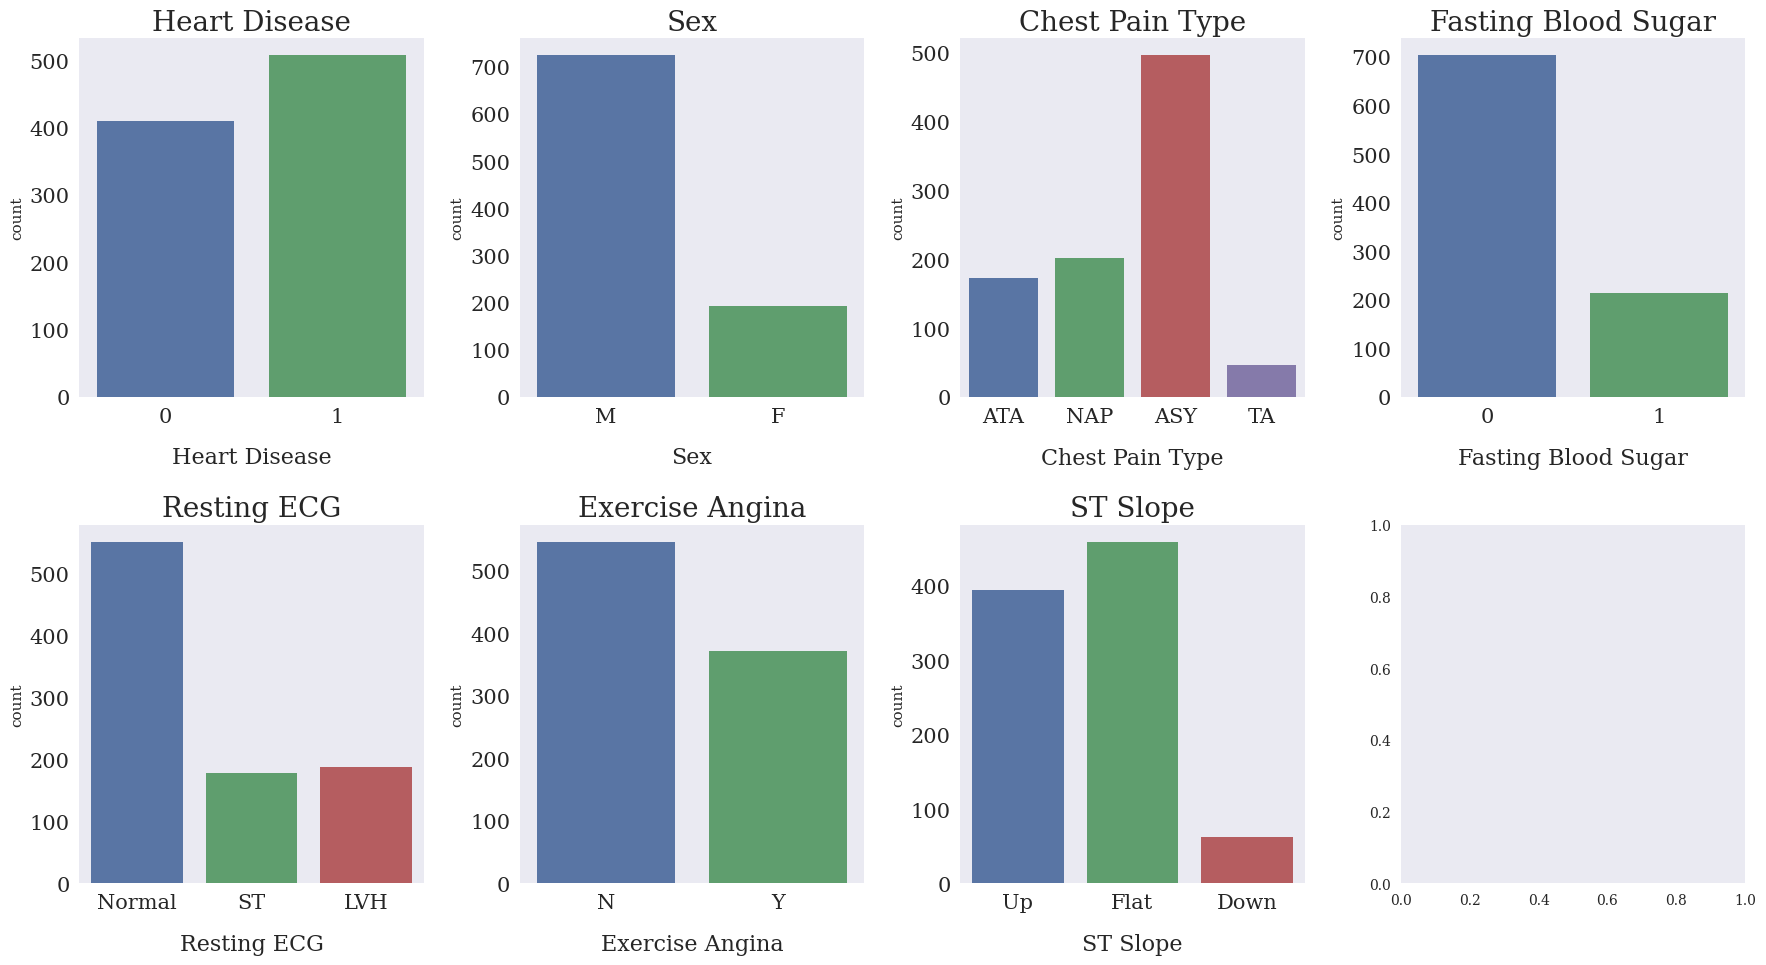

In [23]:
# creates plots going over Categorical Plots
fig, axes = plt.subplots(2,4, figsize=(18,10))

axes = axes.ravel()
cols = ['HeartDisease', 'Sex', 'ChestPainType','FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
titles = ['Heart Disease', 'Sex', 'Chest Pain Type', "Fasting Blood Sugar", 'Resting ECG', "Exercise Angina", 'ST Slope']

for i, col in enumerate(cols):
    sns.countplot(data=heart_df, x=col, ax=axes[i])
    axes[i].set_title(f"{titles[i]}",fontsize='20')
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 15)
    axes[i].set_xlabel(titles[i], fontsize=16, labelpad=15)

plt.tight_layout()

##### Important Take ways from Categorical Data Exploration
* Slight Imbalance in data with more indviduals with Heart disease than not
* There are signficantly more men than women in this dataset
* ASY Chestpain has more instances, while ATA and NAP are close to each other, and TA is the least
* Many have a fasting blood sugar of 0
* Resting ECG is normal for many of the indidvduals in the dataset, ST and LVH are very close to one another
* Over 500 rows have no excercise Angina and around 370 have Excercise Angina
* An ST Slope of Flat is the most common followed by up. Down as the least amount in the dataset

#### Box plots for Numerical Columns

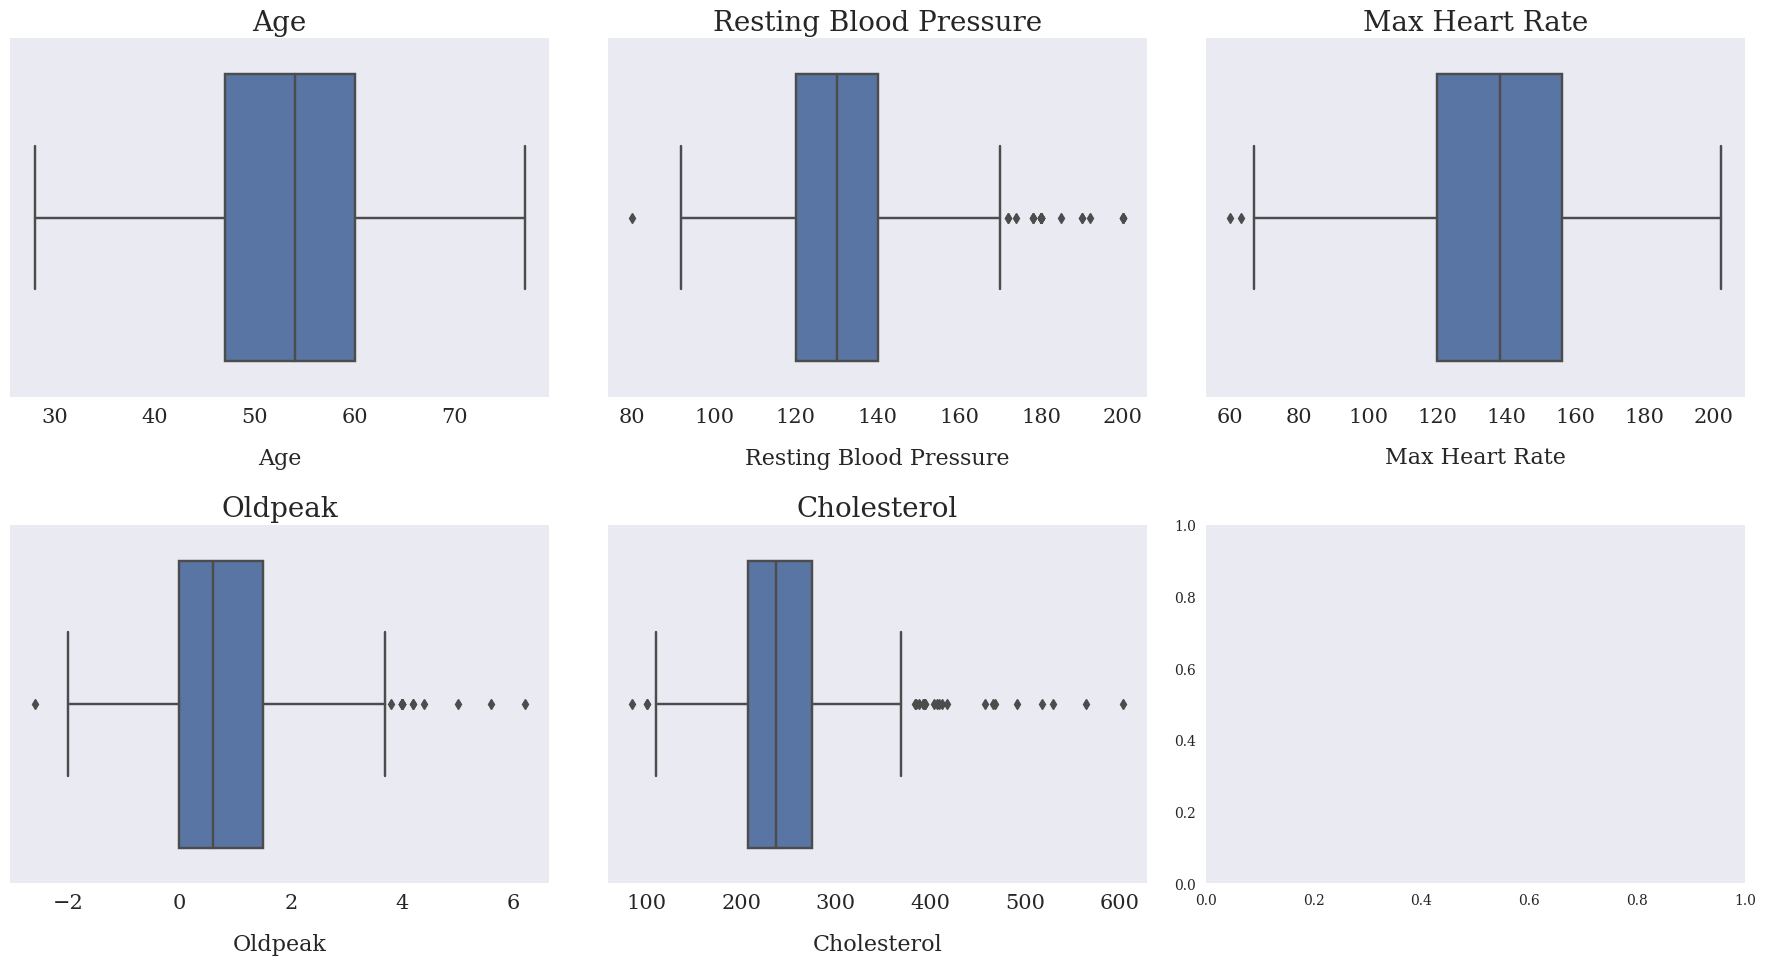

In [24]:
# Create box plots going over Numerical Data to look at outliers
fig, axes = plt.subplots(2,3, figsize=(18,10))

axes = axes.ravel()
cols = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol']
titles = ['Age', "Resting Blood Pressure", "Max Heart Rate", "Oldpeak", "Cholesterol"]

for i, col in enumerate(cols):
    sns.boxplot(data=heart_df, x=col, ax=axes[i])
    axes[i].set_title(f"{titles[i]}",fontsize='20')
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 15)
    axes[i].set_xlabel(titles[i], fontsize=16, labelpad=15)

plt.tight_layout()

# most individuals in thsi dataset fall between 50 and 70

##### Outliers In the Dataset

* Age has no outliers, The ages go between around 30 to 70 years old
* With resting Blood pressure we have 9 Outliers, 1 is around 80, and the other 8 have a resting blood pressure above 170
* Max Heart Rate has 2 outliers, The 2 rows have a heart rate around 60
* Oldpeak has 8 outliers, One is goes below -2, the other 7 go from around 4 to just over 6
* Cholesterol runs between 100 and just under 400. We have 2 outliers with a cholesterol below 100, and the rest range from aroudn 370 to just over 600

### Exploring Correlations

<AxesSubplot:title={'center':'Heatmap Correlations'}>

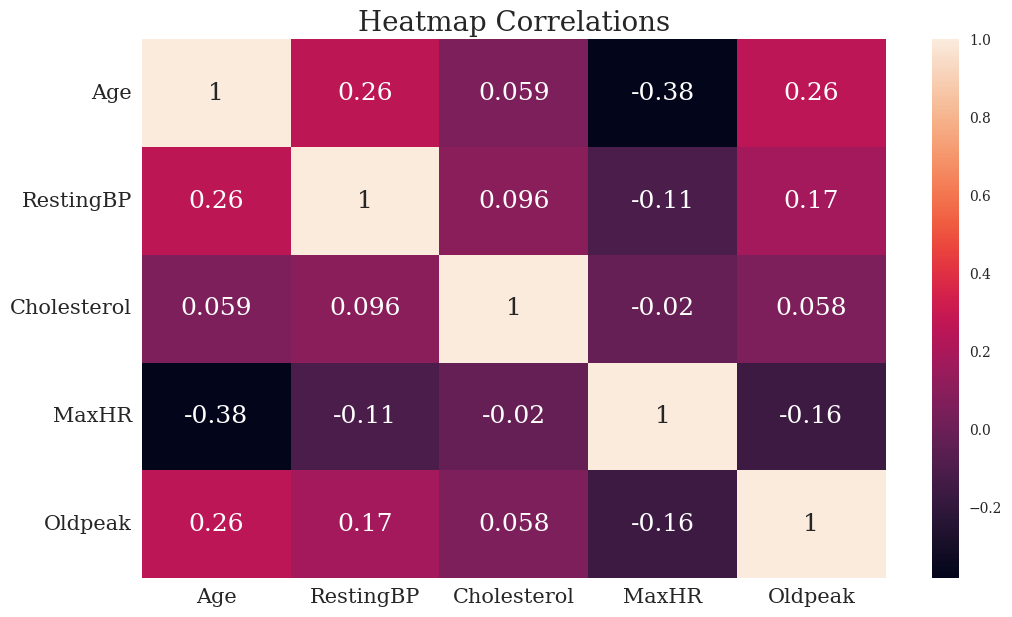

In [25]:
# creating heat  map for correlations
# WE are droppping heart disease from the heatmap bc that is a categorical column
corr = heart_df.drop(columns='HeartDisease').corr()
fig, ax = plt.subplots(figsize=(12,7))
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title("Heatmap Correlations", fontsize='20')
sns.heatmap(data=corr, annot=True, ax=ax)

> Looking at the correlations we can see that there are a few correlations in the dataset. We can see that we have a low negative correlation between Max heart rate and age

### Multivariate Plots

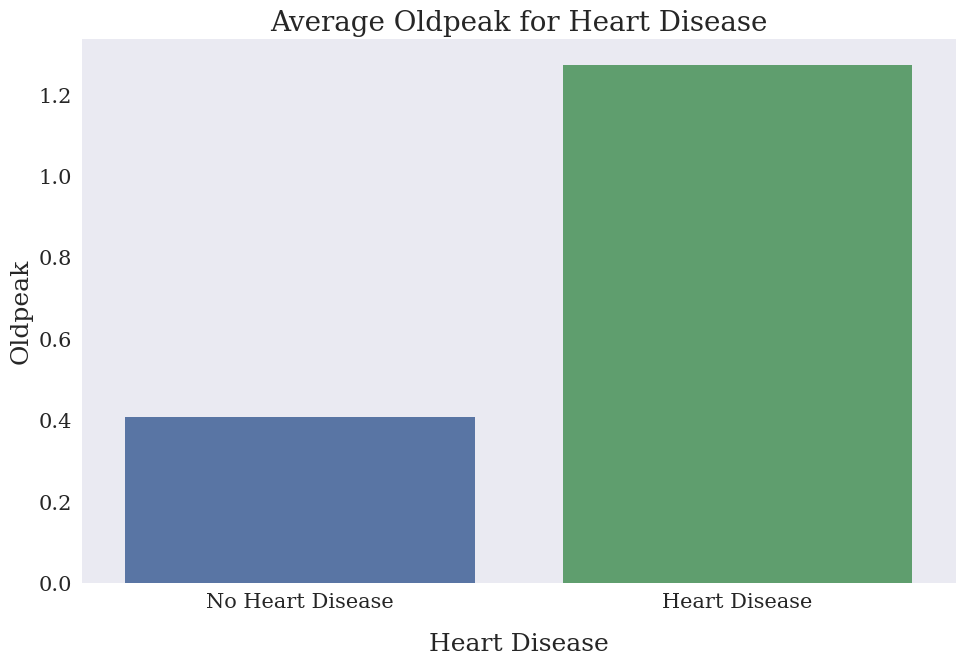

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=heart_df, x='HeartDisease', y='Oldpeak', ax=ax, ci=None)
ax.set_xlabel("Heart Disease", fontsize=18,labelpad=15)
ax.set_xticklabels(['No Heart Disease', "Heart Disease"])
ax.set_ylabel("Oldpeak", fontsize=18)
ax.set_title('Average Oldpeak for Heart Disease', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.tight_layout()

> To understand this graph we first must understand what Oldpeak is. Oldpeak is the depressino of the ST Segment on an EKG. This shows us that indiviudals with heart disease have on average a olpeak of around 1.2. While those wtihout oldpeak have an oldpeak around 0.4. This tells us that oldpeak is can be explored as prominent feature in predicting heart disease in some indivudals.

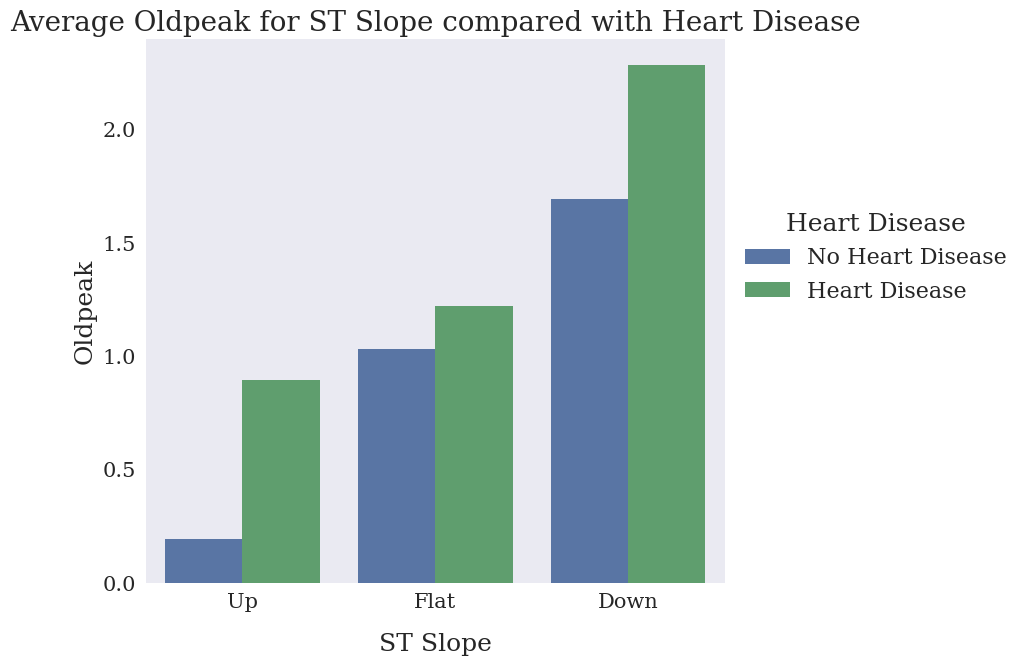

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=heart_df, x='ST_Slope', y='Oldpeak', hue='HeartDisease', ax=ax, ci=None)
ax.set_xlabel("ST Slope", fontsize=18,labelpad=15)
ax.set_ylabel("Oldpeak", fontsize=18)
ax.set_title('Average Oldpeak for ST Slope compared with Heart Disease', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
L = ax.legend(loc=(1.02, .5), fontsize=16, title="Heart Disease")
L.get_texts()[0].set_text('No Heart Disease')
L.get_texts()[1].set_text('Heart Disease')
plt.tight_layout()

> This plot futher explores oldpeak; which is the depression of the ST Segment on an EKG. This time we evaluated the the average Oldpeak based on the type of ST Segment the indidvual has. A lower Oldpeak is seen for those without heart disease

### Preprocessing

In [28]:
heart_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol       float64
FastingBS          object
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [29]:
# Create Num and Cat Selectors
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")


# Creating a mean imputer to replace the nan in cholestorl with the mean of the column, This is so we maintain the mean for the feature overall
mean_imputer = SimpleImputer(strategy='mean')


# Creating Scaler and encoder
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Creating numerical pipe
num_pipe = make_pipeline(mean_imputer, scaler)

# Create tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (ohe, cat_selector)

# Finall Creating preprosessor 
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])

### Model Testing

In [30]:
# Train Test Split


X = heart_df.drop(columns='HeartDisease')
y = heart_df['HeartDisease']

X_train, X_test, y_train,y_test = train_test_split(X,y, random_state=42)

In [31]:
# Helper Function
def eval(grid, X, ytrue):

    preds = grid.best_estimator_.predict(X)
    report = classification_report(ytrue, preds)
    print(report)

    ConfusionMatrixDisplay.from_predictions(ytrue,preds)
    RocCurveDisplay.from_estimator(grid,X, ytrue)

#### Logistic Regression

In [32]:
# Creating Logistic Regression and Pipe 
log = LogisticRegression()
log_pipe = make_pipeline(preprocessor, log)

## Look at logpipe Paramters
log_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipelin

In [33]:
# Creating a dictionary to hold the different paramters. I increased max iterations to give it more time to converge
# and C values were chosen because they increase in a log scale
pipe_params = {
    'logisticregression__C': [.0001, .001, .01, .1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1','l2'],
     'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__max_iter': [10000],
}

In [34]:
## Creating a GridSearch using lop pipe

log_gs = GridSearchCV(log_pipe, pipe_params, scoring='f1_micro')
log_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__max_iter': [10000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='f1_micro')

In [35]:
### Look at Best Params
print(log_gs.best_params_)

{'logisticregression__C': 10, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


Test Report
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        90
           1       0.92      0.86      0.89       140

    accuracy                           0.87       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.87      0.87       230



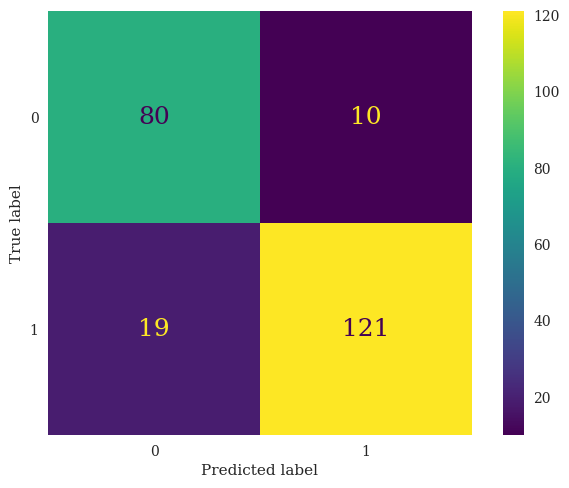

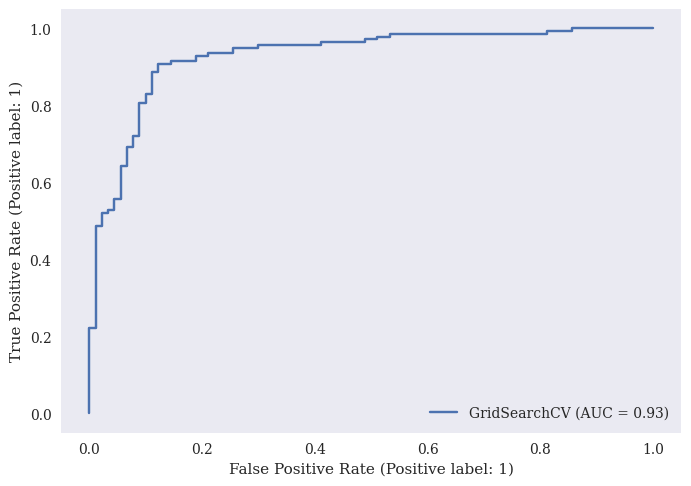

In [36]:
# Test Eval
print("Test Report")
eval(log_gs, X_test, y_test)

Train Report
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       320
           1       0.85      0.88      0.87       367

    accuracy                           0.86       687
   macro avg       0.86      0.85      0.85       687
weighted avg       0.86      0.86      0.86       687



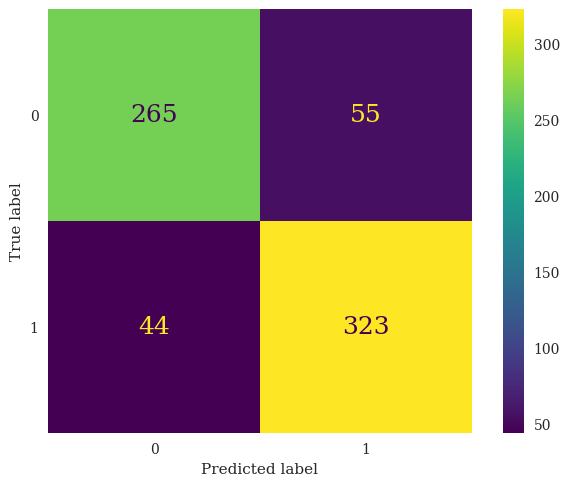

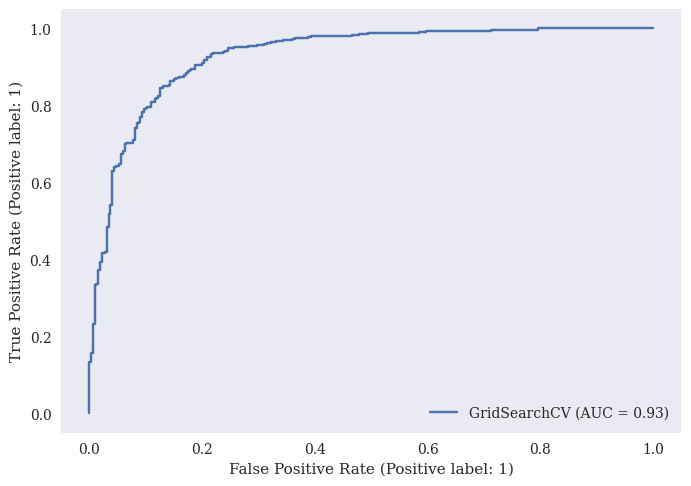

In [37]:
# Train Report
print("Train Report")
eval(log_gs, X_train,y_train)

#### Logistic Regression Analysis

With this Model we got a we got an overall ROC score of 93%. The false negatives came down to 19. 

### KNN

In [38]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)

# Look at paramaters
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pip

In [39]:
# Dictionary to hold the parameters that we want to go through
knn_pipe_params = {
    'kneighborsclassifier__n_neighbors': range(1,50),
    'kneighborsclassifier__p': range(1,5),
    'kneighborsclassifier__weights': ['distance','uniform']
}

In [40]:
# Creating Grid Search using KNN pipe and Pipe params
knn_gs = GridSearchCV(knn_pipe, knn_pipe_params, scoring='f1_micro')

knn_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 50),
                         'kneighborsclassifier__p': range(1, 5),
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']},
             scoring='f1_micro')

In [41]:
# KNN best params
print(knn_gs.best_params_)

{'kneighborsclassifier__n_neighbors': 28, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}


Test Results
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        90
           1       0.92      0.88      0.90       140

    accuracy                           0.88       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.88      0.88       230



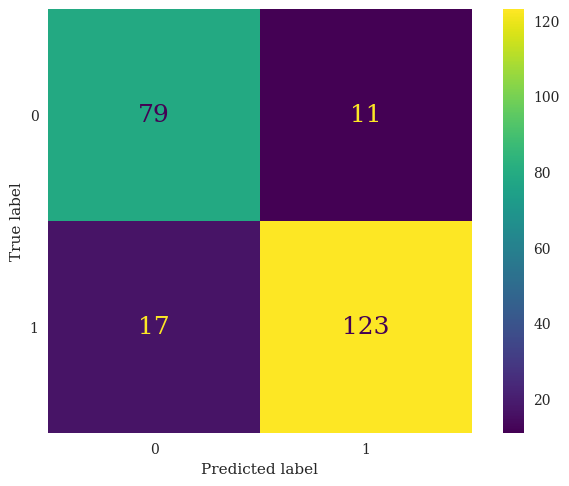

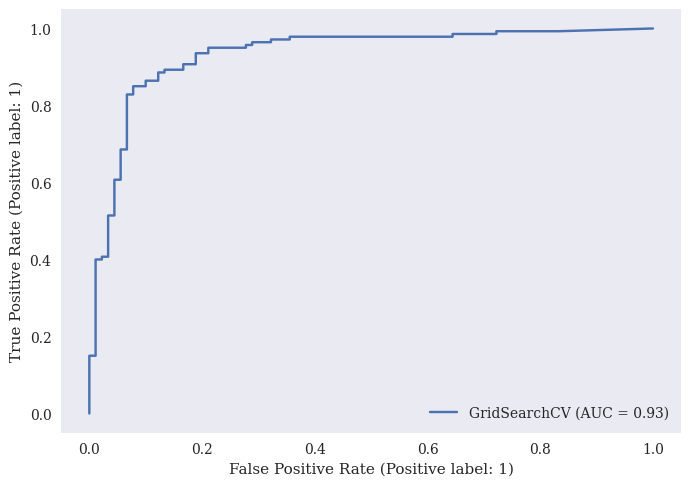

In [42]:
# Evaluating Test Data
print('Test Results')
eval(knn_gs, X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       367

    accuracy                           1.00       687
   macro avg       1.00      1.00      1.00       687
weighted avg       1.00      1.00      1.00       687



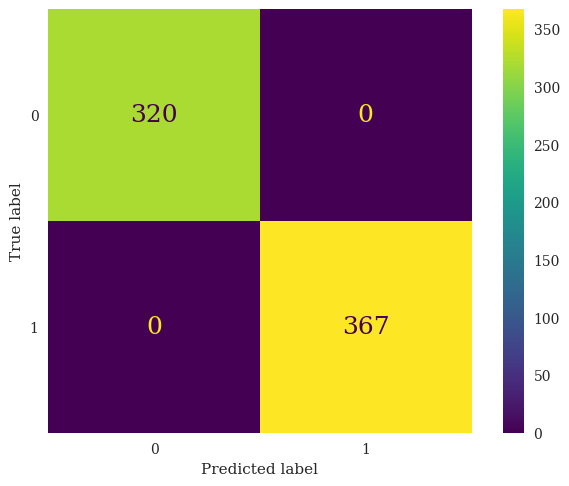

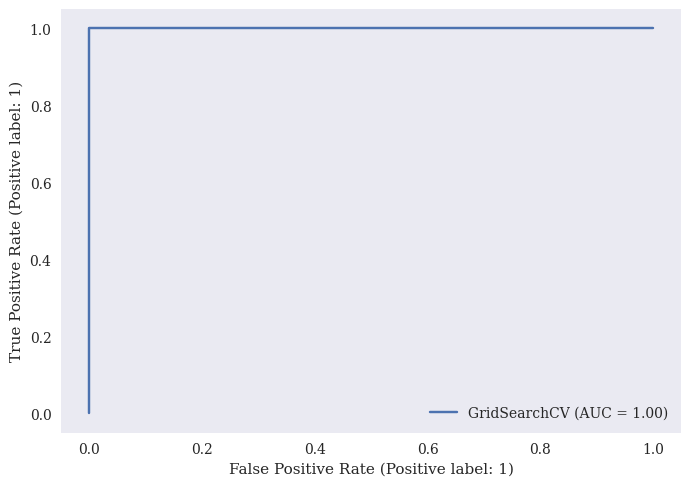

In [43]:
eval(knn_gs, X_train,y_train)

#### KNN Evaluation

The KNN model gave us a 94% ROC Curve, and the false negatives were brought down to 17 compared to the 19 of logistic regression. This model preformed a tad better than Logistic did in minmizing the amount of false negatives. 

### Random Forest

In [44]:
rf = RandomForestClassifier()

# Lets create a preprocessing for Random Forest that imputes the mean and most frequent 
rf_num_tuple = (mean_imputer, num_selector)
rf_cat_tuple = (ohe, cat_selector)
rf_preprocessing = make_column_transformer(rf_num_tuple, rf_cat_tuple)

rf_preprocessing

ColumnTransformer(transformers=[('simpleimputer', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])

In [45]:
# Creating dictionary of params to go through
rf_param_grid = {
    'randomforestclassifier__max_depth': range(1,50),
     'randomforestclassifier__n_estimators': [2,10,30,50,100,150,200,250,500],
}

In [46]:

rf_pipe = make_pipeline(rf_preprocessing, rf)

rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('simpleimputer', SimpleImputer(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                               

In [47]:
# Creating grid 
rf_grid = GridSearchCV(rf_pipe,rf_param_grid, scoring='f1_micro')


# Fitting data to grid
rf_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': range(1, 50),
                         'randomforestclassifier__n_estimators': [2, 10, 30, 50,
                                                                  100, 150, 200,
                                                                  250, 500]},
             scoring='f1_micro')

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        90
           1       0.92      0.89      0.90       140

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



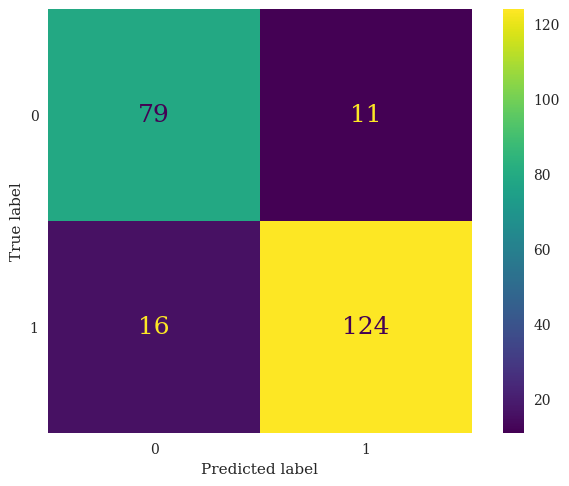

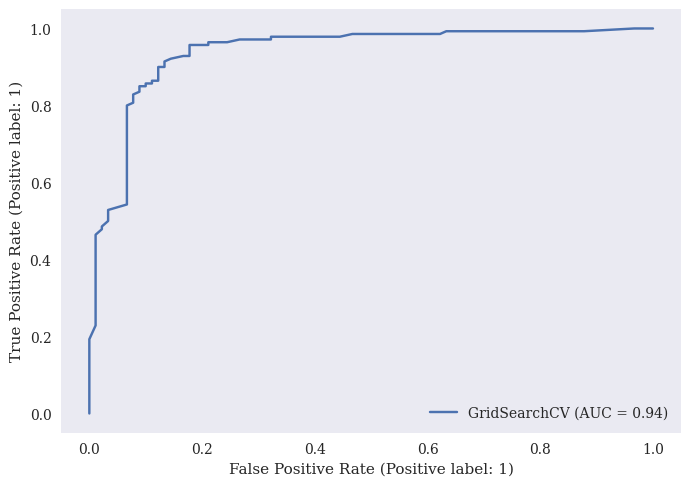

In [48]:
eval(rf_grid,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       367

    accuracy                           1.00       687
   macro avg       1.00      1.00      1.00       687
weighted avg       1.00      1.00      1.00       687



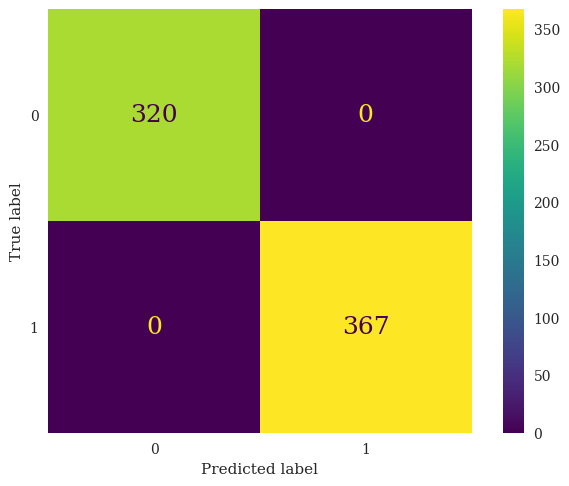

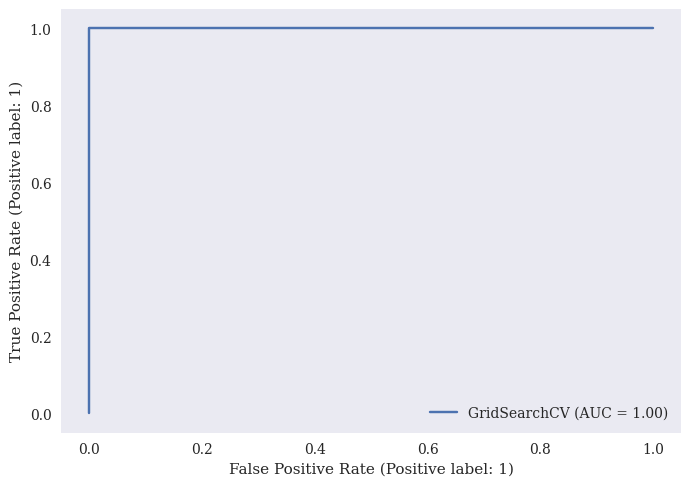

In [49]:
eval(rf_grid,X_train,y_train)

### Random Forest Evaluation

Random Forest preformed fairly well with with the test data, We had 18 false negatives putting better than logistic regression worse than knn. The only downside to this model was the time it spent in fitting the data.

### Feature Engineering

#### PCA

In [50]:
## Create PCA Preprocessor

# Creating our pipelines
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(ohe, scaler)

# Creating Tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

# Creating Column Transformer
pca_preprocessor = make_column_transformer(num_tuple, cat_tuple)

pca_preprocessor


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])

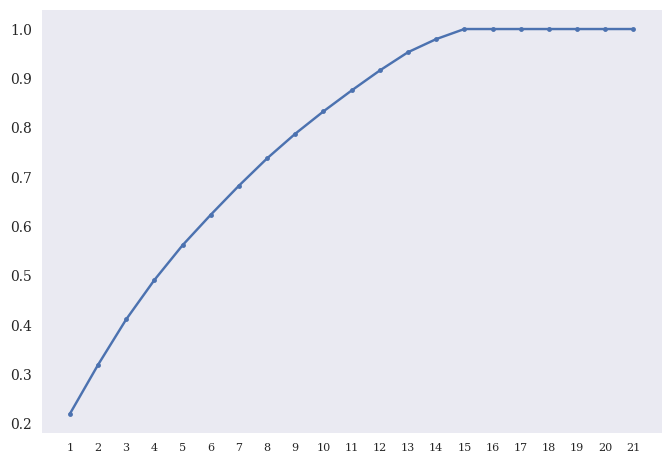

In [51]:
scaled_x_train = pca_preprocessor.fit_transform(X_train)
pca = PCA()
pca.fit(scaled_x_train)

plt.plot(range(1,22), pca.explained_variance_ratio_.cumsum(), marker='.')
plt.xticks(ticks=range(1,22), fontsize=8);


Text(0, 0.5, 'Proportion of Explained Variance')

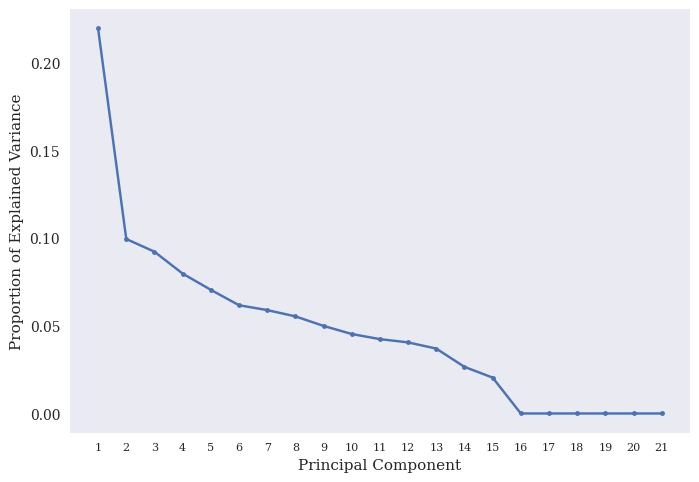

In [52]:
# Scree Plot
plt.plot(range(1,22), pca.explained_variance_ratio_, marker='.')
plt.xticks(ticks = range(1, 22), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

In [53]:
# Points of Interest are 2, and 13
pca = PCA(n_components=13)

### Logistic Regression with PCA

In [54]:
log_pca = LogisticRegression()
log_pipe_pca = make_pipeline(pca_preprocessor,pca, log_pca)

In [55]:
## Creating a GridSearch and Finding best Params
log_gs_pca = GridSearchCV(log_pipe_pca, pipe_params, scoring='f1_micro')
log_gs_pca.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknow...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
                                       ('pca', PCA(n_components=13)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__max_iter': [10000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='f1_micro')

In [56]:
print(log_gs_pca.best_params_)

{'logisticregression__C': 0.01, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}


Test Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        90
           1       0.92      0.85      0.88       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



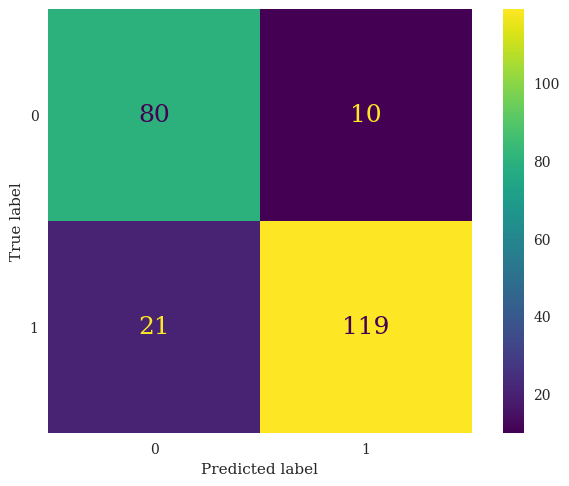

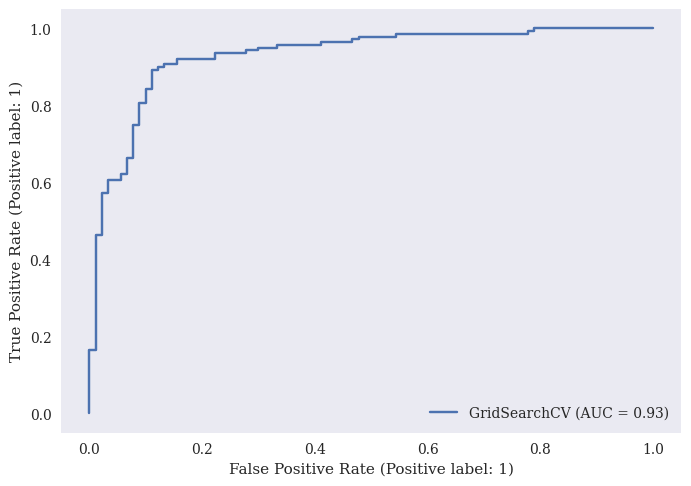

In [57]:
print("Test Report")
eval(log_gs_pca, X_test,y_test)

Train Report
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       320
           1       0.85      0.89      0.87       367

    accuracy                           0.86       687
   macro avg       0.86      0.86      0.86       687
weighted avg       0.86      0.86      0.86       687



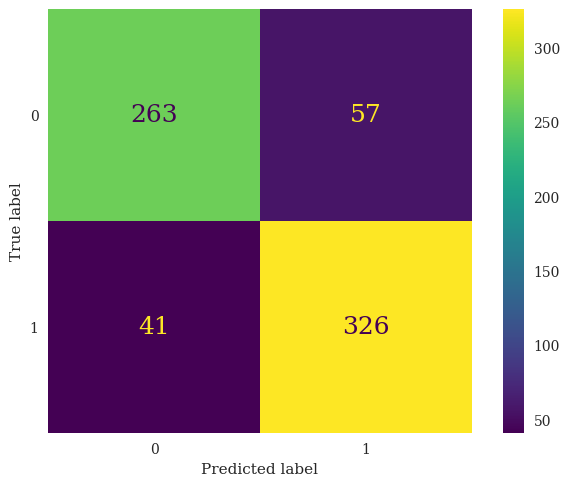

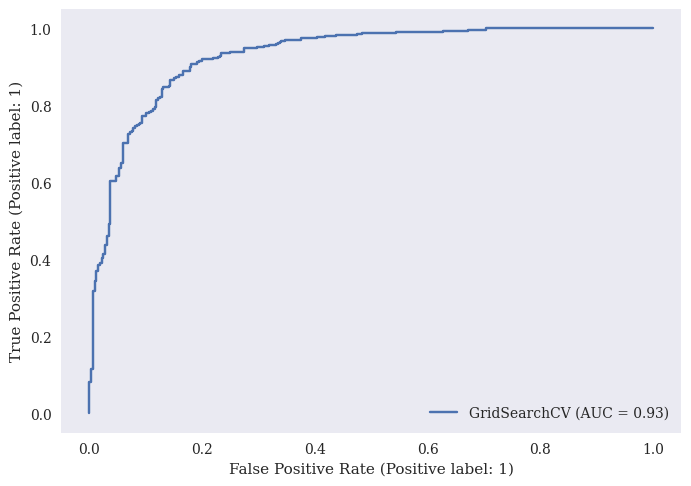

In [58]:
print("Train Report")
eval(log_gs_pca, X_train,y_train)

#### Logistic Regression with PCA Evaluation

The model preformed worse by 1 percent on the ROC curve with PCA,and the false negatives was the same as if we did use pca. 21 False negatives, so overall pca did not help with overall preforming with logistic regression

### KNN with PCA

In [59]:
knn_pca = KNeighborsClassifier()
knn_pipe_pca = make_pipeline(pca_preprocessor,pca, knn_pca)

In [60]:
knn_gs_pca = GridSearchCV(knn_pipe_pca, knn_pipe_params, scoring='f1_micro')

knn_gs_pca.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknow...
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
                                       ('pca', PCA(n_components=13)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 50),
                         'kneighborsclassifier__p': range(1, 5),
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']},
             scoring='f1_micro')

In [61]:
print(knn_gs_pca.best_params_)

{'kneighborsclassifier__n_neighbors': 28, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'distance'}


Test Report
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        90
           1       0.91      0.88      0.89       140

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.88      0.87      0.87       230



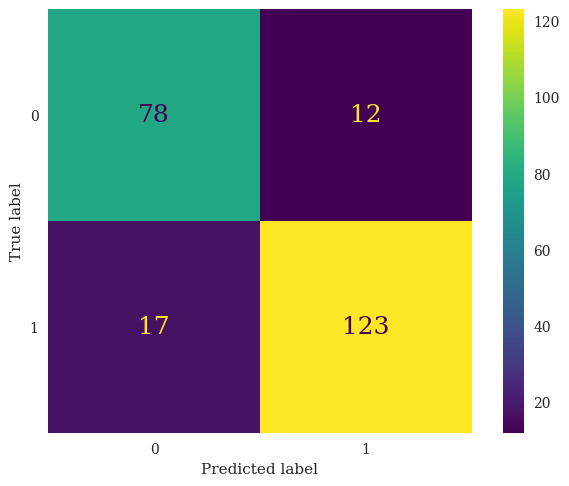

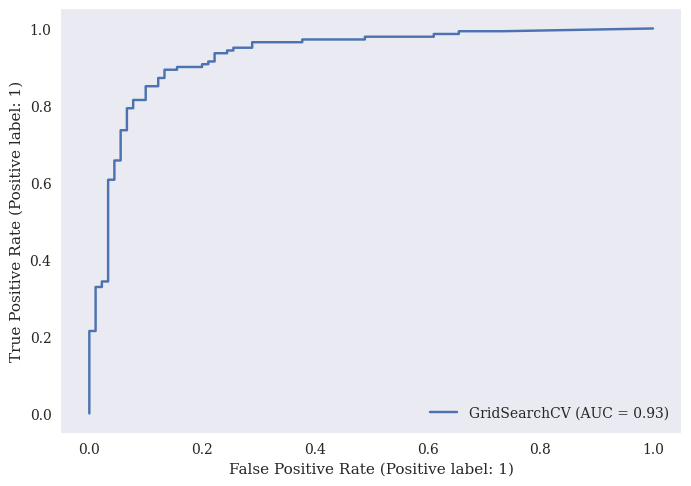

In [62]:
print("Test Report")
eval(knn_gs_pca,X_test,y_test)

Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       367

    accuracy                           1.00       687
   macro avg       1.00      1.00      1.00       687
weighted avg       1.00      1.00      1.00       687



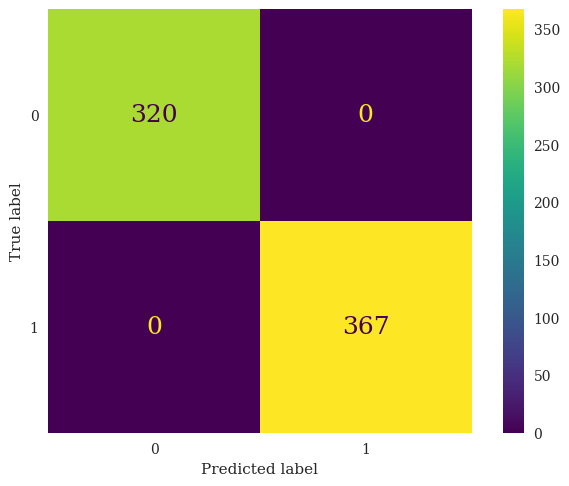

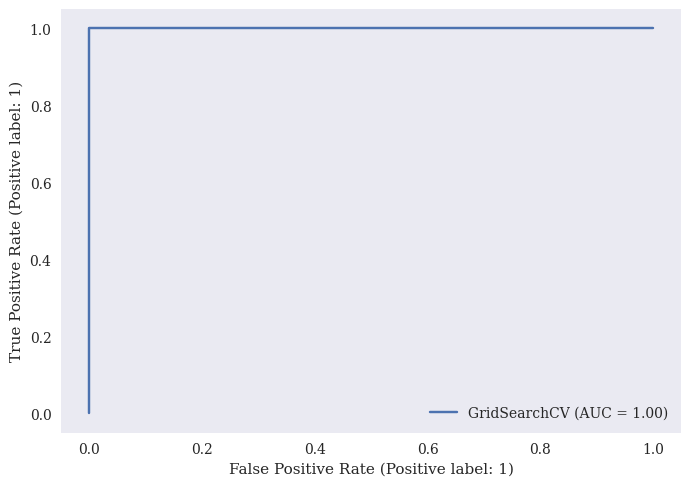

In [63]:
print('Train Report')
eval(knn_gs_pca, X_train,y_train)

#### KNN with PCA

With PCA the model actually around the same as when we did not use PCA, Our false negatives remained the same as without pca of at 17 and our ROC Curve was at 93%

### Random Forest with PCA

In [64]:
rf_pca = RandomForestClassifier()

In [65]:
rf_pipe_pca = make_pipeline(pca_preprocessor,pca ,rf_pca)

In [66]:
# Creating grid 
rf_grid_pca = GridSearchCV(rf_pipe_pca,rf_param_grid, scoring='f1_micro')


# Fitting data to grid
rf_grid_pca.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031c0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknow...
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f13d6a031f0>)])),
                                       ('pca', PCA(n_components=13)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': range(1, 50),
                         'randomforestclassifier__n_estimators': [2, 10, 30, 50,
                                                                  100, 150, 200,
                                                                  250, 500]},
             scoring='f1_micro')

In [67]:
print(rf_grid_pca.best_params_)

{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50}


Test Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        90
           1       0.91      0.86      0.89       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



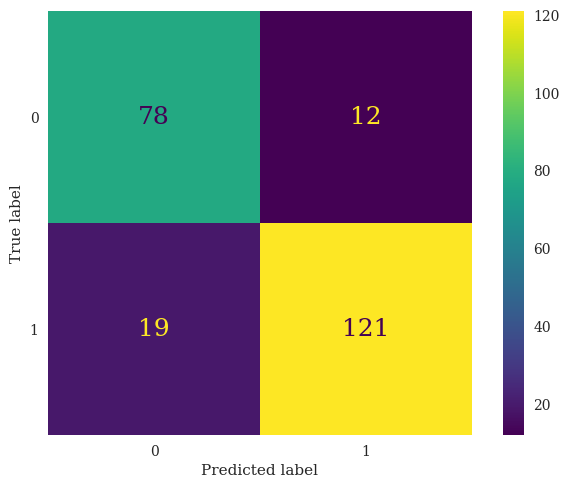

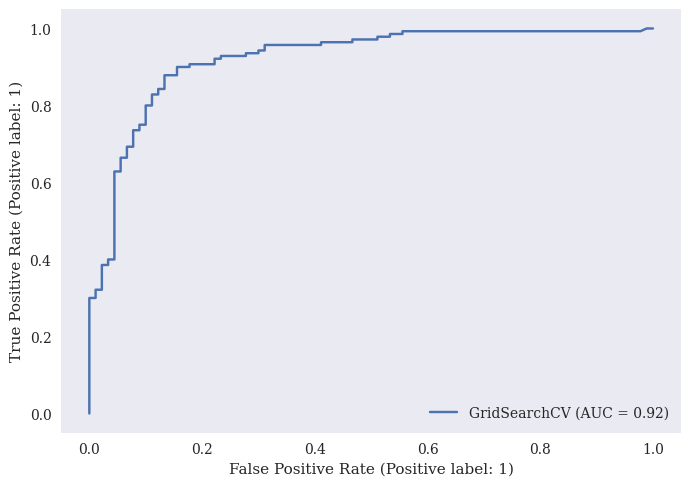

In [68]:
print('Test Report')
eval(rf_grid_pca, X_test,y_test)

Train Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       320
           1       0.89      0.95      0.92       367

    accuracy                           0.91       687
   macro avg       0.91      0.91      0.91       687
weighted avg       0.91      0.91      0.91       687



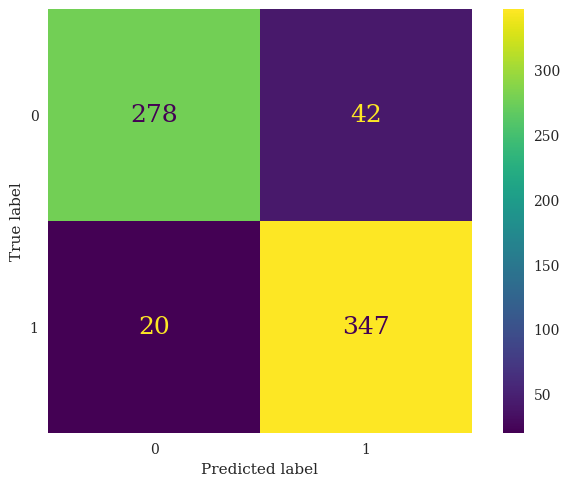

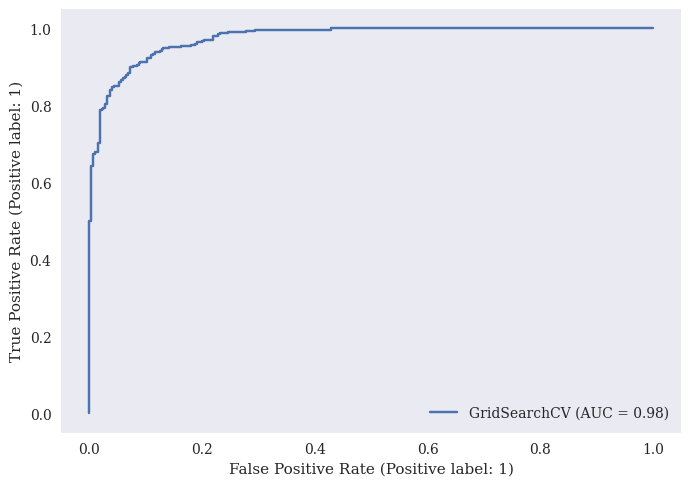

In [69]:
print('Train Report')
eval(rf_grid_pca, X_train,y_train)

#### Random Forest with PCA

With PCA Random Forest gave us a 91% ROC curve with 86% accuracy it actually increased the number of false negatives by 1 giving us 21 false negatives compared to the 18 that Random Forest without PCA gave us.This took significantly longer than using without PCA by almost 3 minutes.

### Recommendations with PCA

PCA did not add much to the models. In KNN and Random Forest the model actually peformed worse in lowering our False Negatives. Thus I would recommend not using PCA with our data set

### Production Model

For Production we will use KNN without PCA, This model is being chosen because it had managed to reduce false negatives the most leaving us with 17 false negatives. This is important so we are not telling indivduals they dont have Heart Disease when they do. 

In [70]:
print(knn_gs.best_params_)

{'kneighborsclassifier__n_neighbors': 28, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}


              precision    recall  f1-score   support

           0       0.82      0.88      0.85        90
           1       0.92      0.88      0.90       140

    accuracy                           0.88       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.88      0.88       230



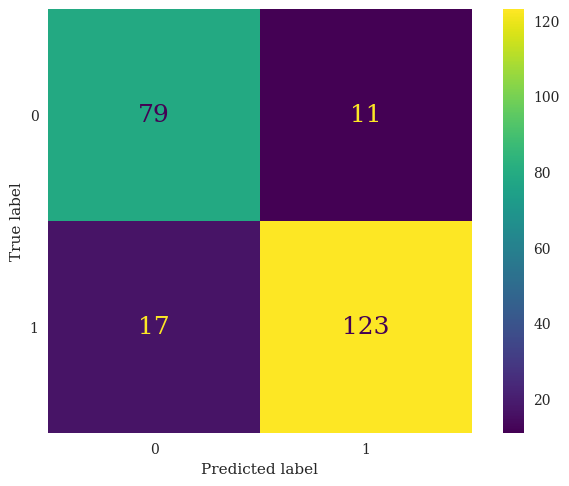

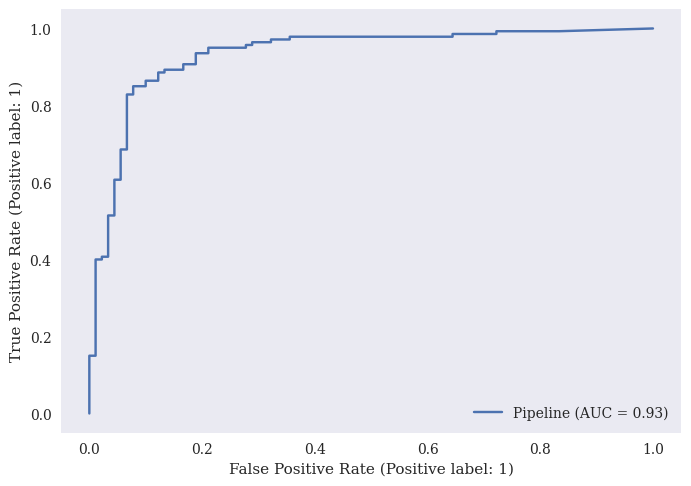

In [71]:
final_model = knn_gs.best_estimator_
final_model.fit(X_train,y_train)

preds = final_model.predict(X_test)

report = classification_report(y_test,preds)
print(report)


ConfusionMatrixDisplay.from_estimator(final_model,X_test, y_test)
RocCurveDisplay.from_estimator(final_model, X_test,y_test)

### Model Evaluation

The final model recommended for this project is a KNN model. This model was chosen because it gave us the highest ROC curve with 93% on the testing data. Anther important aspect was that it had minimum False Negatives. This is important because we do not want to tell an individual that they do not have heart disease when they actually do. This model gaves us a precision of 92% and a recall of 88% for having heart disease which was in line with many of other models used in the project. The best preforming parameters that were found using Grid Search were 19 n neighbors, a p score of 1 and weight of distance. 